## Extracting and Saving Primary Neutrino Energy Data

This section extracts the **primary neutrino energy** from a ROOT file using `km3io` and saves it as a CSV file for further analysis.

### **Purpose of the Process:**
- **Reading Simulation Data**: The `OfflineReader` loads Monte Carlo (MC) data from a ROOT file containing simulated neutrino interactions.
- **Filtering Primary Neutrino Events**: 
  - The selection criterion `status == 100` ensures that only **primary neutrino tracks** are extracted.
  - The energy values (`E`) of these primary neutrino tracks are then **flattened** into a 1D array.
- **Creating a Pandas DataFrame**: The extracted energy values are stored in a structured format, making it easier to manipulate and analyze.
- **Saving as CSV**: The final dataset is saved as **'Primary_Neutrino_Energy.csv'**, allowing easy access for external processing or visualization.

### **Significance:**
- This step provides **cleaned and structured energy data** from simulated neutrino interactions, which is essential for model training and evaluation.
- The CSV format allows for **seamless integration** with various data analysis tools, including Python-based ML frameworks.

In [255]:
import pandas as pd
import awkward as ak
import km3io as ki

r = ki.OfflineReader('/Users/meskara/Documents/Energy_Reconstruction/mcv6.4.gsg_nue-NCHEDIS_1e2-1e8GeV.sirene.jterbr00009985.jchain.aanet.253.root')

primary_neutrino_energy = ak.flatten(r[r.mc_tracks.status == 100].mc_tracks.E, axis=1)

df_energy = pd.DataFrame({'Energy': primary_neutrino_energy})

df_energy.to_csv('Primary_Neutrino_Energy.csv', index=False)

print("Filtered energy data saved to 'Primary_Neutrino_Energy.csv'")

Filtered energy data saved to 'Primary_Neutrino_Energy.csv'


## Importing Necessary Libraries

This section imports essential libraries required for **data analysis, visualization, and machine learning**.

### **Data Handling and Visualization:**
- `pandas`: Used for data manipulation and analysis.
- `matplotlib.pyplot`: Provides plotting functions for visualizing data trends.
- `numpy`: Enables numerical computations and array manipulations.
- `seaborn`: Enhances visualization aesthetics and statistical analysis.

### **Machine Learning Models:**
- `RandomForestRegressor`, `GradientBoostingRegressor`: Ensemble learning models for regression.
- `KNeighborsRegressor`: A k-Nearest Neighbors regression model.

### **Model Training and Evaluation:**
- `train_test_split`: Splits the dataset into training and testing sets.
- `mean_absolute_error`, `mean_squared_error`, `r2_score`: Metrics for evaluating regression model performance.
- `StandardScaler`: Standardizes input features to improve model training efficiency.

### **Deep Learning (Neural Networks) with TensorFlow/Keras:**
- `Sequential`: A linear stack of layers for building neural networks.
- `Dense`, `Dropout`: Fully connected layers and dropout regularization.
- `Conv1D`, `Flatten`: Convolutional and flattening layers for feature extraction.
- `Adam`: An optimizer for training deep learning models.

### **Purpose:**
These imports enable a complete **machine learning workflow**, from preprocessing data and training models to evaluating their performance. The combination of traditional machine learning models and deep learning architectures provides flexibility in selecting the best approach for energy reconstruction.

In [256]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam

## Loading and Preparing Data

This section loads two datasets from CSV files and ensures they are properly structured for further analysis.

### **Datasets:**
1. **Truth Data (`df_truth`)**:
   - Contains detailed information about simulated neutrino interactions.
   - Loaded from `"All_fields_in_one_file.csv"`.
  
2. **Reconstructed Data (`df_reco`)**:
   - Contains the extracted primary neutrino energy values.
   - Loaded from `"Primary_Neutrino_Energy.csv"`.

### **Preprocessing Steps:**
- **Resetting Index**: 
  - Ensures that both datasets have a **continuous index** after loading.
  - Avoids potential inconsistencies in indexing that could affect merging or alignment.

### **Purpose:**
- This step prepares the datasets for **feature extraction, model training, and comparison between true and reconstructed energy values**.
- Ensuring proper alignment of indices is crucial for accurate model input and evaluation.

In [257]:
df_truth = pd.read_csv("/Users/meskara/Documents/Energy_Reconstruction/All_fields_in_one_file.csv")
df_reco = pd.read_csv("/Users/meskara/Documents/Energy_Reconstruction/Primary_Neutrino_Energy.csv")

df_truth = df_truth.reset_index(drop=True)
df_reco = df_reco.reset_index(drop=True)

## Selecting Features and Target Variable

This section extracts relevant features (`X`) and the target variable (`y`) from the loaded datasets.

### **Feature Selection (`X`)**:
The selected features from `df_truth` include:
- **Temporal Information**: `t`, `tdc` (time-related features).
- **Spatial Coordinates**: `pos_x`, `pos_y`, `pos_z` (position in the detector).
- **Directionality**: `dir_x`, `dir_y`, `dir_z` (directional components).
- **Signal Properties**: `tot` (time-over-threshold), `a` (a dataset parameter).
- **Trigger Information**: `trig` (indicates event registration).

> **Note**: Features such as `id`, `id_channel`, and `id_dim` are excluded since they are identifiers and may not contribute to the prediction.

### **Target Variable (`y`)**:
- The **primary neutrino energy** is extracted from `df_reco['Energy']`.
- Since energy spans multiple orders of magnitude, a **logarithmic transformation** is applied:

$$
y_{\text{log}} = \log_{10}(y)
$$

### **Purpose**:
- Feature selection ensures the model receives relevant inputs for energy reconstruction.
- The logarithmic transformation stabilizes variance and helps the model generalize across different energy scales.

In [258]:
X = df_truth[['t', 'tdc', 'pos_x', 'pos_y', 'pos_z', 'dir_x', 'dir_y', 'dir_z', 'tot', 'a', 'trig']]  # Features without id, id channel, id dim
y = df_reco['Energy']  
y_log = np.log10(y)  

## Standardizing Features

To ensure that all features contribute equally to the model, **feature standardization** is applied using `StandardScaler`.

### **Why Standardize?**
1. **Removes Scale Differences**: Features such as position (`pos_x`, `pos_y`, `pos_z`) and time (`t`, `tdc`) have different units and magnitudes.
2. **Improves Model Performance**: Many machine learning algorithms (especially gradient-based methods) perform better when features are standardized.
3. **Reduces Sensitivity to Outliers**: Standardization mitigates the impact of extreme values.

### **Standardization Formula:**
$$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$$
where:
- $\mu$ is the mean of each feature.
- $\sigma$ is the standard deviation.

### **Implementation:**
- `StandardScaler().fit_transform(X)` computes the mean and standard deviation for each feature and scales the data accordingly.

### **Purpose:**
- Ensures **consistent feature scaling**, improving model efficiency and training stability.

In [259]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [260]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

## Reverting Log Transformation of the Target Variable

Since we applied a **logarithmic transformation** to the energy values earlier:

$$
y_{\text{log}} = \log_{10}(y)
$$

we now reverse this transformation to obtain the **original energy values**:

$$
y_{\text{test original}} = 10^{y_{\text{test log}}}
$$

### **Why Revert the Log Transformation?**
1. **Interpretability**: The model predicts `log10(E)`, but we need actual energy values for meaningful evaluation.
2. **Comparison with True Values**: Regression performance metrics like MAE and MSE must be calculated using original-scale energy values.
3. **Post-processing for Analysis**: If results are used in scientific applications or visualizations, they must be in their original physical units.

### **Purpose:**
This step ensures that model predictions and true energy values are in the **same scale**, allowing accurate performance evaluation.

In [261]:
y_test_original = 10 ** y_test_log

## Defining Machine Learning Models

This section initializes multiple machine learning models for energy reconstruction. Using an ensemble of different models allows for performance comparison and selection of the most effective approach.

### **Models Used:**
1. **Random Forest Regressor (`RandomForestRegressor`)**:
   - An ensemble learning method that combines multiple decision trees.
   - Uses **500 trees** (`n_estimators=500`) to improve accuracy and reduce overfitting.
   - Provides **robust predictions** and captures complex feature relationships.

2. **Gradient Boosting Regressor (`GradientBoostingRegressor`)**:
   - A boosting algorithm that builds trees sequentially, correcting previous errors.
   - Uses **200 estimators** (`n_estimators=200`) for optimized performance.
   - Works well for structured data and captures **non-linear dependencies**.

3. **k-Nearest Neighbors (`KNeighborsRegressor`)**:
   - A **non-parametric** algorithm that predicts values based on the nearest 5 (`n_neighbors=5`) training samples.
   - Effective for **local pattern recognition** but may struggle with high-dimensional data.

### **Purpose:**
- This model dictionary (`models`) allows for efficient training and comparison of multiple algorithms.
- Each model has **unique strengths**, making it valuable to assess different learning strategies.

In [262]:
models = {

    "Random Forest": RandomForestRegressor(n_estimators=500, random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "k-neighbors": KNeighborsRegressor(n_neighbors=5)
}

## Defining an Artificial Neural Network (ANN) for Regression

This section constructs a **feedforward neural network** using Keras' `Sequential` API for energy reconstruction.

### **Neural Network Architecture:**
1. **Input Layer (`Dense(64)`)**:
   - First fully connected (dense) layer with **64 neurons**.
   - Uses **ReLU activation** to introduce non-linearity.
   - `input_dim=X_train.shape[1]` ensures compatibility with feature dimensions.

2. **Hidden Layers**:
   - **Second layer**: `Dense(32, activation='relu')` (32 neurons).
   - **Third layer**: `Dense(16, activation='relu')` (16 neurons).
   - Each layer progressively reduces dimensionality, capturing **abstract representations** of features.

3. **Output Layer (`Dense(1)`)**:
   - A single neuron with **no activation function** (linear output).
   - Designed for **regression tasks**, predicting continuous energy values.

### **Compilation:**
- **Optimizer (`Adam`)**:
  - Adaptive gradient-based optimization that efficiently updates weights.
  - Well-suited for deep learning tasks.
- **Loss Function (`mean_squared_error`)**:
  - MSE minimizes the squared difference between true and predicted values.
  - Standard choice for regression problems.

### **Purpose:**
- The ANN aims to **learn complex, non-linear relationships** in the data.
- Compared to tree-based models, deep learning can potentially capture **hidden patterns** that improve prediction accuracy.

In [263]:
Ann = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Single output for regression
])
Ann.compile(optimizer=Adam(), loss='mean_squared_error')

/Users/meskara/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Reshaping Data for Convolutional Neural Network (CNN)

Since Convolutional Neural Networks (CNNs) typically operate on multi-dimensional data (such as images or sequences), we **reshape the input feature matrices** to a format suitable for a 1D CNN.

### **Transformation Applied:**
$$
X_{\text{train CNN}} = X_{\text{train}}.reshape(\text{samples}, \text{features}, 1)
$$
$$
X_{\text{test CNN}} = X_{\text{test}}.reshape(\text{samples}, \text{features}, 1)
$$

### **Why Reshape?**
- CNNs expect input in the form **(samples, time steps, channels)**.
- Here, each feature vector is treated as a **1D sequence**, with **one channel** (like grayscale image channels).
- This allows the CNN to learn **spatial correlations** between features.

### **Purpose:**
- This transformation ensures that **CNN layers** can properly process the structured input.
- Helps leverage **convolutional filters** to extract patterns in the feature space.

In [264]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [265]:
print(X_train_cnn.shape)
print(X_test_cnn.shape)

(2642, 11, 1)
(661, 11, 1)


## Defining a Convolutional Neural Network (CNN) for Regression

This section constructs a **1D Convolutional Neural Network (CNN)** to model energy reconstruction.

### **CNN Architecture:**
1. **First Convolutional Layer (`Conv1D(64)`)**:
   - Applies **64 filters** with a **kernel size of 2** to extract local patterns between adjacent features.
   - Uses **ReLU activation** to introduce non-linearity.
   - `input_shape=(X_train_cnn.shape[1], 1)` ensures compatibility with reshaped data.

2. **Dropout Layer (`Dropout(0.5)`)**:
   - Randomly drops **50% of neurons** to reduce overfitting and improve generalization.

3. **Second Convolutional Layer (`Conv1D(32)`)**:
   - Applies **32 filters** to further extract meaningful representations.
   - Again uses **ReLU activation**.

4. **Flattening Layer (`Flatten()`)**:
   - Converts the **2D feature maps** from convolutional layers into a **1D vector** for dense layers.

5. **Fully Connected Layers (`Dense(16)`, `Dense(1)`)**:
   - **First Dense Layer (`Dense(16)`)**: Uses **16 neurons** with ReLU activation.
   - **Output Layer (`Dense(1)`)**: A single neuron for regression output, predicting energy values.

### **Compilation:**
- **Optimizer (`Adam`)**: Adaptive gradient-based optimization for efficient weight updates.
- **Loss Function (`mean_squared_error`)**: MSE is used to measure the squared difference between actual and predicted values.

### **Purpose:**
- CNNs are typically used for image processing, but here, they **capture local dependencies** between features.
- Unlike fully connected networks, CNNs help extract patterns in feature space **more efficiently**, potentially improving regression performance.

In [266]:
cnn = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    Dropout(0.5),
    Conv1D(32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1)  
])
cnn.compile(optimizer=Adam(), loss='mean_squared_error')

/Users/meskara/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
results = {}

In [268]:
for model_name, model in models.items():
    model.fit(X_train, y_train_log)

    y_pred_log = model.predict(X_test)

    y_pred = 10 ** y_pred_log

    mae = mean_absolute_error(y_test_original, y_pred)
    mse = mean_squared_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)

    results[model_name] = {"MAE": mae, "MSE": mse, "R2": r2, "y_pred": y_pred}

    print(f"{model_name} Performance:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R2 Score: {r2}\n")

Random Forest Performance:
MAE: 3975715.1113687847
MSE: 193972175036659.6
R2 Score: 0.04698759327069979

GradientBoostingRegressor Performance:
MAE: 4133931.727834941
MSE: 191023055609282.06
R2 Score: 0.061477029204931255

k-neighbors Performance:
MAE: 4243663.719613509
MSE: 206015019633398.56
R2 Score: -0.012180585416970535



In [269]:
Ann.fit(X_train, y_train_log, epochs=50, batch_size=32, verbose=0)
y_pred_log_ann = Ann.predict(X_test).flatten()
y_pred_ann = 10 ** y_pred_log_ann

mae_dnn = mean_absolute_error(y_test_original, y_pred_ann)
mse_dnn = mean_squared_error(y_test_original, y_pred_ann)
r2_dnn = r2_score(y_test_original, y_pred_ann)
results["Deep Neural Network"] = {"MAE": mae_dnn, "MSE": mse_dnn, "R2": r2_dnn, "y_pred": y_pred_ann}

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [270]:
cnn.fit(X_train_cnn, y_train_log, epochs=50, batch_size=32, verbose=0)
y_pred_log_cnn = cnn.predict(X_test_cnn).flatten()
y_pred_cnn = 10 ** y_pred_log_cnn

mae_cnn = mean_absolute_error(y_test_original, y_pred_cnn)
mse_cnn = mean_squared_error(y_test_original, y_pred_cnn)
r2_cnn = r2_score(y_test_original, y_pred_cnn)
results["Convolutional Neural Network"] = {"MAE": mae_cnn, "MSE": mse_cnn, "R2": r2_cnn, "y_pred": y_pred_cnn}

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [271]:
metrics = ['MAE', 'MSE', 'R2']
num_metrics = len(metrics)
x = np.arange(len(results))

## Comparing Model Performance with Bar Charts

This visualization provides a comparative analysis of different models based on selected performance metrics.

### **Plot Features:**
- **Multiple Bar Charts**:
  - Each subplot corresponds to a different evaluation metric (e.g., MAE, MSE, R²).
  - Bars represent the performance values for each model.

- **X-axis (`Model Names`)**:
  - Displays the names of the evaluated models.
  - Rotated labels (`rotation=45`) for readability.

- **Y-axis (`Metric Values`)**:
  - Represents the computed metric values for each model.
  - For **MAE (Mean Absolute Error) and MSE (Mean Squared Error)**, a **log scale** is used to better represent differences in error magnitude.

- **Bar Alignment (`align='center'`)**:
  - Ensures each model's performance metric is centered in the corresponding category.

### **Purpose:**
- This bar chart allows for **quick visual comparison** of different models.
- Highlights which models perform best based on various metrics.
- Helps identify trade-offs (e.g., lower MAE vs. higher R²).

This visualization aids in selecting the most effective model for energy reconstruction.

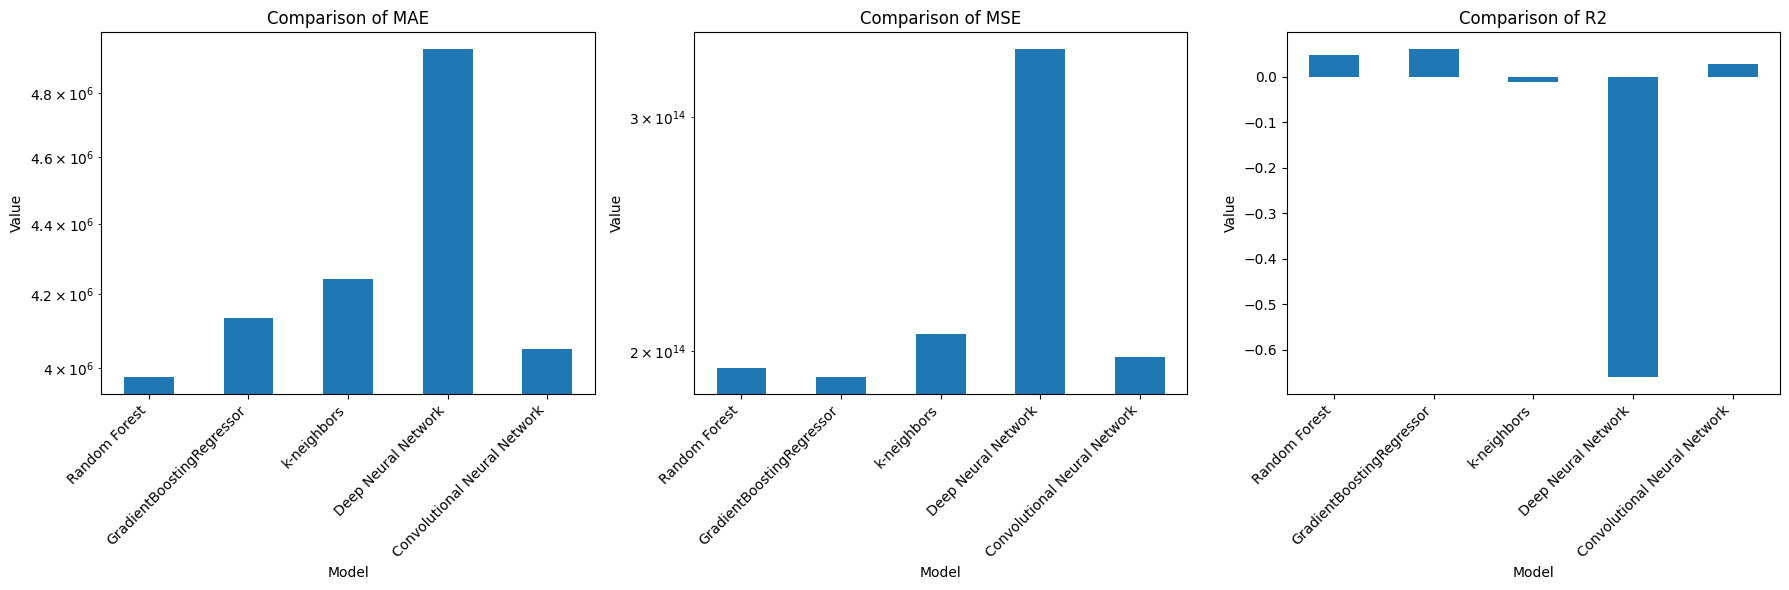

In [272]:
fig, axes = plt.subplots(1, num_metrics, figsize=(18, 6))

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results]
    axes[i].bar(x, values, width=0.5, align='center')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(results.keys(), rotation=45, ha="right")
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel('Value')
    axes[i].set_title(f'Comparison of {metric}')
    if metric in ['MAE', 'MSE']:
        axes[i].set_yscale('log')  

plt.tight_layout()
plt.show()

In [273]:
BINS = np.logspace(1,9,40)

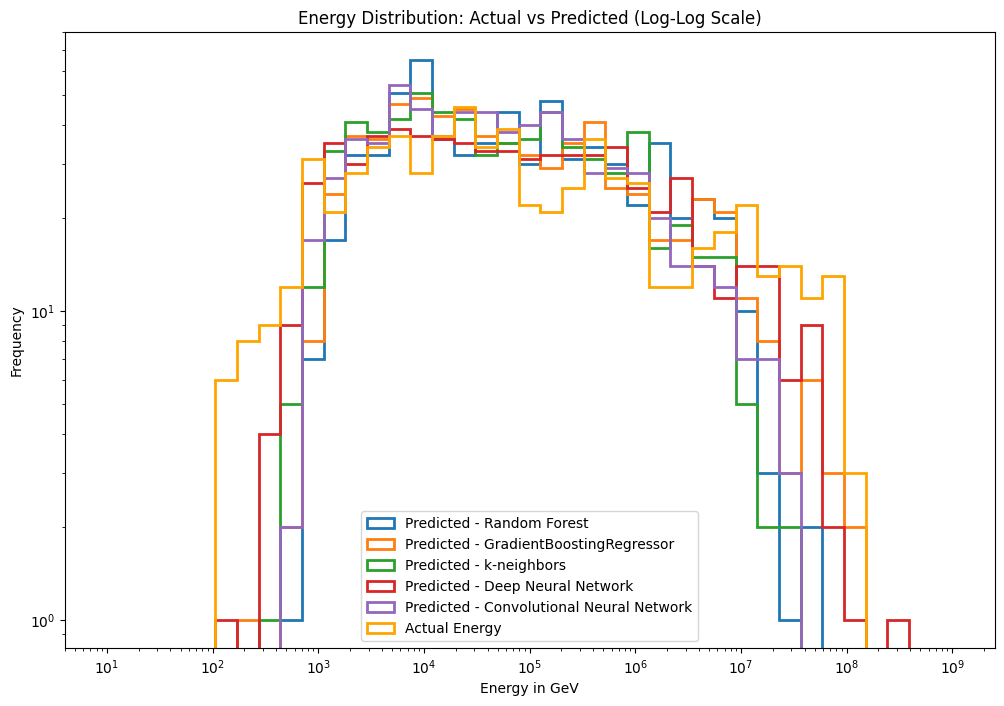

In [274]:
plt.figure(figsize=(12, 8))

for model_name, model_results in results.items():
    
    y_pred = model_results["y_pred"]
    plt.hist(y_pred, bins=BINS, histtype='step', linewidth=2, label=f'Predicted - {model_name}')

plt.hist(y_test_original, bins=BINS, histtype='step', color='orange', linewidth=2, label='Actual Energy')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy in GeV')
plt.ylabel('Frequency')
plt.title('Energy Distribution: Actual vs Predicted (Log-Log Scale)')

plt.legend()
plt.show()

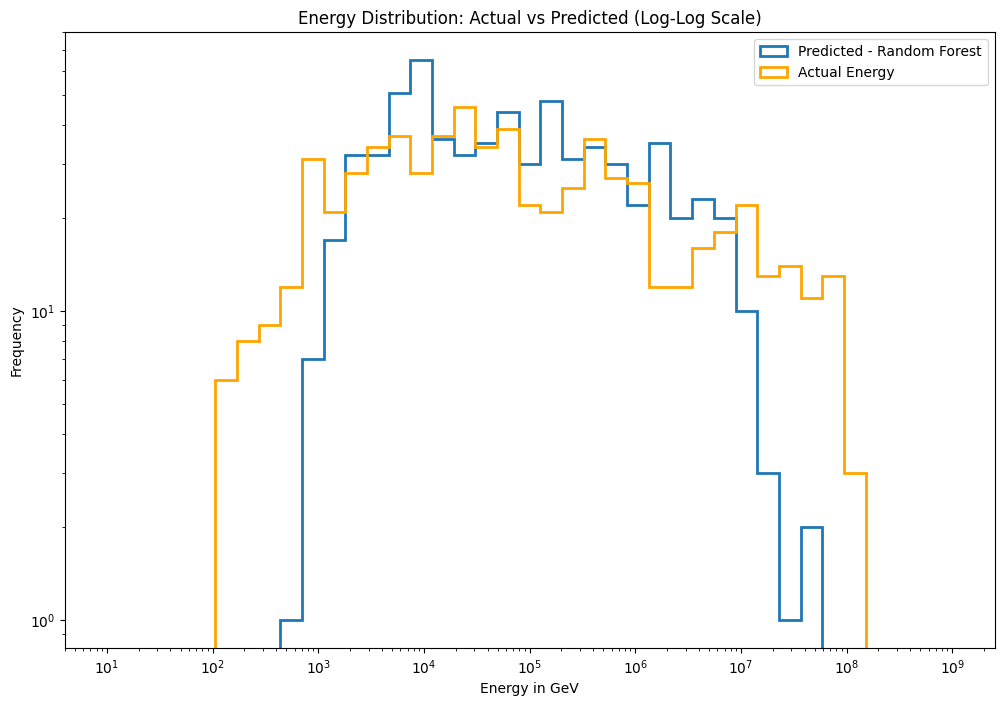

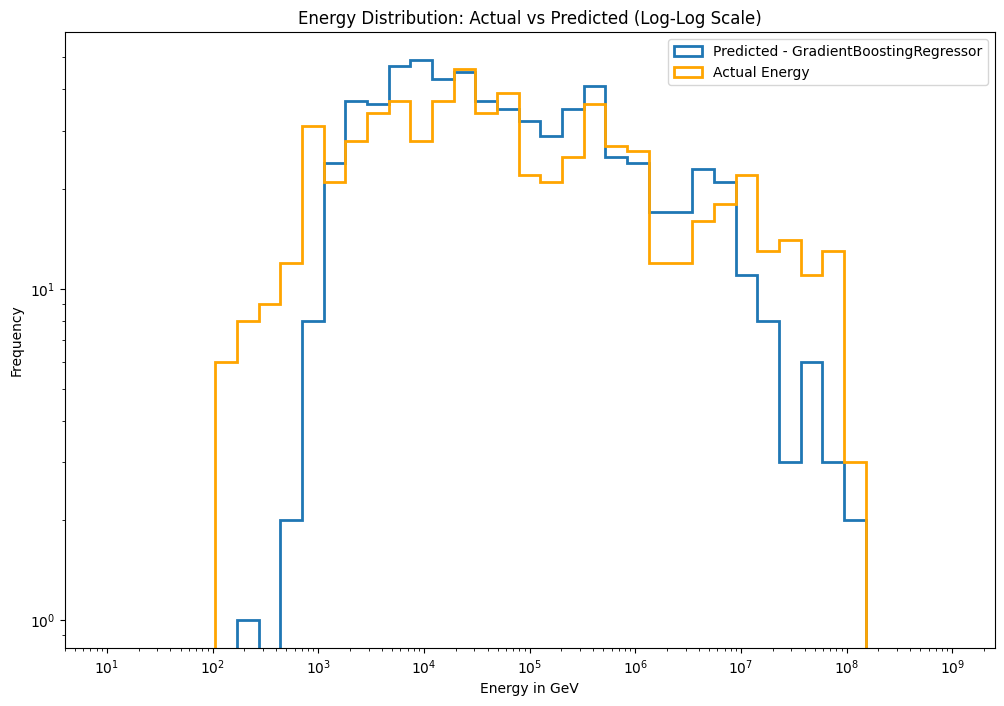

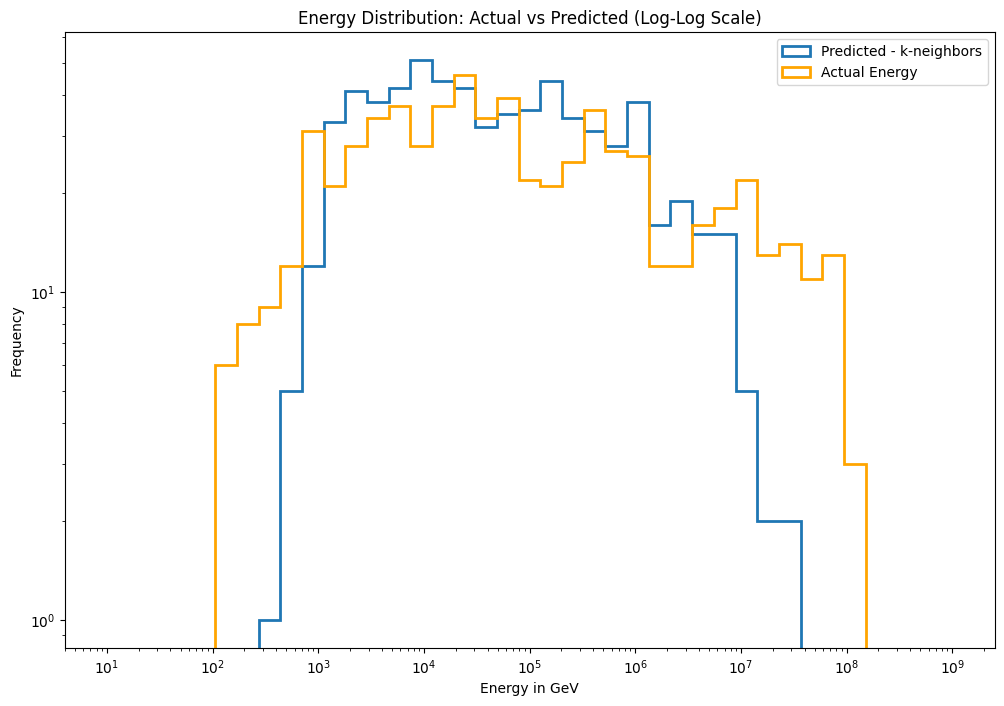

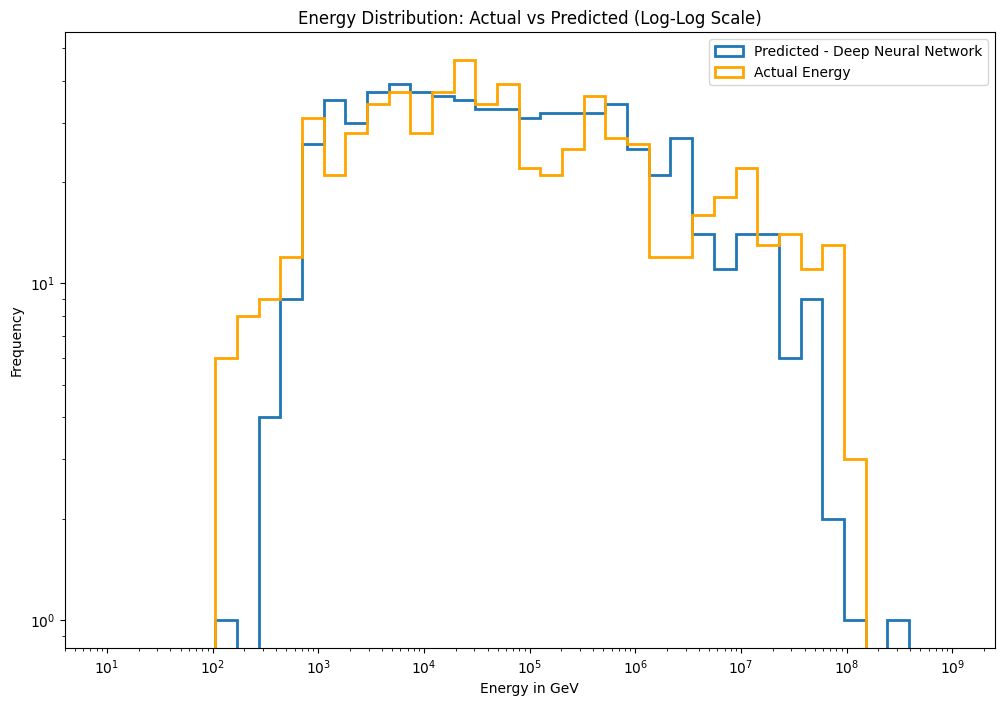

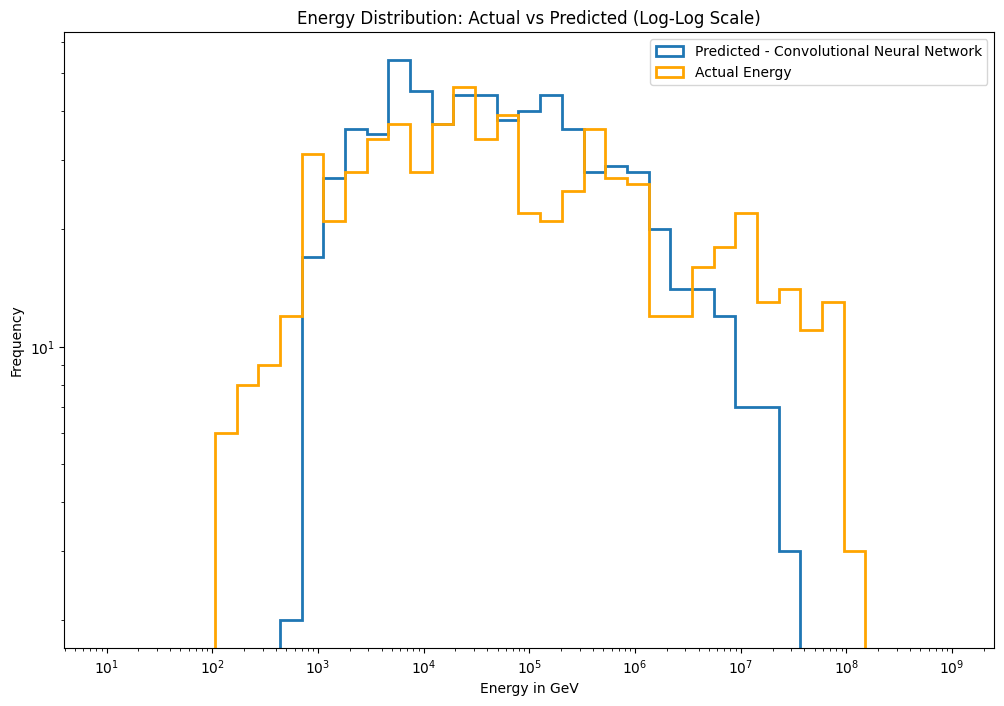

In [275]:

for model_name, model_results in results.items():
    
    y_pred = model_results["y_pred"]
    plt.figure(figsize=(12, 8))

    plt.hist(y_pred, bins=BINS, histtype='step', linewidth=2, label=f'Predicted - {model_name}')

    plt.hist(y_test_original, bins=BINS, histtype='step', color='orange', linewidth=2, label='Actual Energy')

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel('Energy in GeV')
    plt.ylabel('Frequency')
    plt.title('Energy Distribution: Actual vs Predicted (Log-Log Scale)')

    plt.legend()
    plt.show()